### Program description:
This program designs the model to later be used to generate CIFAR10 features to feed into APML for classification.
Rather than starting from scratch, we use transfer learning by borrowing the pre-trained weights obtained by the famous VGGNET16 network that was trained on ImageNet data. Our goal is to train our network to classify CiFar10 images which are 32x32x3, while imagenet's files are 128x128x3, so we only use the early (3) layers of the VGG16 network, and train our own final layers to fit our data. This will cut down on time and optimize performance with respect to CiFar10.

After training the model, it is saved to a .h5 file to be later extracted and used to generate features for use with APML.

In [1]:
#import statements
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

import cnn_utils as utils
from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')


In [2]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.engine import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

Using TensorFlow backend.


### Global declaration of hyperparameters and other items

In [3]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

## Obtain and pre-process data

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
print(y_train.shape)

#create an additional 20% split from training data for validation sets (for tuning model) stratified among the training data
x_red, x_val, y_red, y_val = train_test_split(x_train, y_train, test_size=0.15, 
                                                  stratify=np.array(y_train), random_state=42)

#transform the labels with one-hot encoding
Y_red = np_utils.to_categorical(y_red, NUM_CLASSES)
Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

#scale x data
X_train=x_train.astype('float32')/255.0
X_test=x_test.astype('float32')/255.0


(50000, 32, 32, 3)
(50000, 1)


## Create a new model from pre-trained ImageNet weights from VGG16 (use transfer learning)

In [5]:
#first, load the pre-trained VGG16 model from ImageNET, excluding the top layer so we can add our own for cifar10
base_model=vgg.VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
for layer in base_model.layers:
    print(layer.name, layer.output_shape)

input_1 (None, 32, 32, 3)
block1_conv1 (None, 32, 32, 64)
block1_conv2 (None, 32, 32, 64)
block1_pool (None, 16, 16, 64)
block2_conv1 (None, 16, 16, 128)
block2_conv2 (None, 16, 16, 128)
block2_pool (None, 8, 8, 128)
block3_conv1 (None, 8, 8, 256)
block3_conv2 (None, 8, 8, 256)
block3_conv3 (None, 8, 8, 256)
block3_pool (None, 4, 4, 256)
block4_conv1 (None, 4, 4, 512)
block4_conv2 (None, 4, 4, 512)
block4_conv3 (None, 4, 4, 512)
block4_pool (None, 2, 2, 512)
block5_conv1 (None, 2, 2, 512)
block5_conv2 (None, 2, 2, 512)
block5_conv3 (None, 2, 2, 512)
block5_pool (None, 1, 1, 512)


## Extract the first 3 layers from the existing VGGNet16 network.
The more similar the tasks are, the more layers you want to reuse (always starting with lower layers). For very similar tasks,  keep all the hidden layers and just replace the output layer. In this case, we chose to keep 3/5 of the hidden layers because of the differences in dimensions.

In [6]:
#extract the last layer from the 3rd block of the vgg16 model, cutting off the last 2 convolution blocks
# and the final classification section
last = base_model.get_layer('block3_pool').output

Here is a brief description of what the customized final layers of the network do:
-global average pooling layer - this computes the mean of each entire feature map, outputting a simgle number per feature map and per instance. 
-batch normalization  - to reduce the danger of vanishing/exploding gradients. This zero-centers and normalizes each input (over the batch), then scales and shifts the result using two new parameter vectors per layer (one ofr scaling and the other for shifting).
-dropout - for regularization and only during training

In [7]:
#Add a global average pooling layer, BN, 2 densely connected layers and dropout before classifying
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
# Create a custom classification layer to predict the 10 classes of the cifar10 data
pred = Dense(NUM_CLASSES, activation='softmax')(x)
#append the new 'final' layers to the base model
model = Model(base_model.input, pred)

freeze training on pretrained layers in the model. Since our model uses the base model's layers directly rather than the base_model itself, setting base_ model.trainable=False would have no effect.

In [8]:
#freeze training on lower layers in the model (those in base_layers) because these were learned from VGGNET on imagenet
for layer in base_model.layers:
    layer.trainable = False

In [9]:
#compile model and start training
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [10]:
#perform training on the full training dataset
import time
from keras.callbacks import ModelCheckpoint, EarlyStopping

start = time.time()
print(model.summary())
#add checkpoints
checkpoint = ModelCheckpoint("vgg16_xferINall.h5", monitor = 'val_acc', verbose=0, save_best_only=True,
        save_weights_only=False, mode='auto')
    
#add early termination
early=EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
    
# fit model
history = model.fit(x=X_train, y=Y_train, epochs=100, batch_size=32, 
                        validation_split=0.1, callbacks=[checkpoint], verbose=1)   
# evaluate the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
 
# save architecture of the model for recreation, weights, training configuration, and state of the optimizer
model.save("cifar10_vggnet_xferINv2.h5")
model.save_weights('cifar_vggnet_xferINv2.h5')
print("Saved model to disk")
end = time.time()
# total time taken
print(f"Runtime of the program in minutes is {(end - start)/60}")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

Epoch 38/100
45000/45000 [==============================] - 313s 7ms/step - loss: 0.0845 - accuracy: 0.9672 - val_loss: 0.1156 - val_accuracy: 0.9565
Epoch 39/100
45000/45000 [==============================] - 314s 7ms/step - loss: 0.0821 - accuracy: 0.9683 - val_loss: 0.1171 - val_accuracy: 0.9563
Epoch 40/100
45000/45000 [==============================] - 312s 7ms/step - loss: 0.0820 - accuracy: 0.9683 - val_loss: 0.1169 - val_accuracy: 0.9554
Epoch 41/100
45000/45000 [==============================] - 313s 7ms/step - loss: 0.0816 - accuracy: 0.9685 - val_loss: 0.1166 - val_accuracy: 0.9568
Epoch 42/100
45000/45000 [==============================] - 311s 7ms/step - loss: 0.0800 - accuracy: 0.9690 - val_loss: 0.1180 - val_accuracy: 0.9560
Epoch 43/100
45000/45000 [==============================] - 317s 7ms/step - loss: 0.0791 - accuracy: 0.9695 - val_loss: 0.1178 - val_accuracy: 0.9560
Epoch 44/100
45000/45000 [==============================] - 310s 7ms/step - loss: 0.0785 - accuracy:

45000/45000 [==============================] - 311s 7ms/step - loss: 0.0511 - accuracy: 0.9805 - val_loss: 0.1350 - val_accuracy: 0.9548
Epoch 93/100
45000/45000 [==============================] - 312s 7ms/step - loss: 0.0514 - accuracy: 0.9803 - val_loss: 0.1354 - val_accuracy: 0.9535
Epoch 94/100
45000/45000 [==============================] - 313s 7ms/step - loss: 0.0504 - accuracy: 0.9805 - val_loss: 0.1356 - val_accuracy: 0.9538
Epoch 95/100
45000/45000 [==============================] - 310s 7ms/step - loss: 0.0503 - accuracy: 0.9807 - val_loss: 0.1380 - val_accuracy: 0.9535
Epoch 96/100
45000/45000 [==============================] - 314s 7ms/step - loss: 0.0507 - accuracy: 0.9802 - val_loss: 0.1392 - val_accuracy: 0.9528
Epoch 97/100
45000/45000 [==============================] - 311s 7ms/step - loss: 0.0501 - accuracy: 0.9807 - val_loss: 0.1367 - val_accuracy: 0.9533
Epoch 98/100
45000/45000 [==============================] - 314s 7ms/step - loss: 0.0492 - accuracy: 0.9811 - val

In [12]:
import cnn_utils as utils
from model_evaluation_utils import get_metrics
# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',         
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

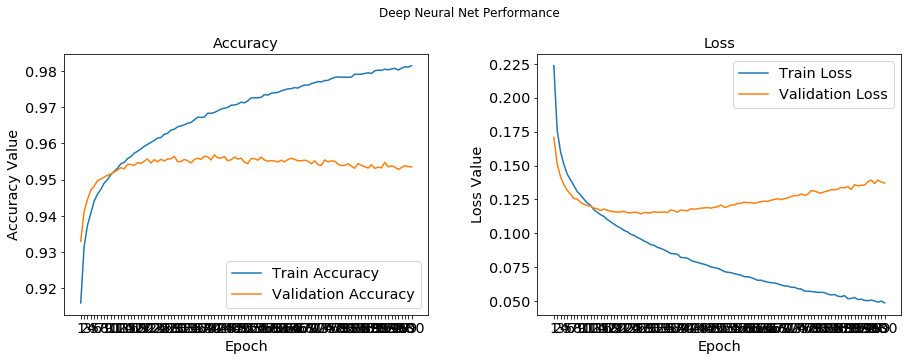

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")